# 사전 학습된 MobileNet 모델을 이용한 전이 학습

* Custom Task : 공개된 ImageNet 데이터셋으로 사전 훈련된 MobileNet 모델을 가지고 온 후, Transfer learning을 활용하여 고양이와 개의 이미지를 분류


* Custom Task를 수행하기 위해 Custom Dataset으로 모델을 처음부터 학습시키지 않고, Transfer Learning을 많이 활용하는 이유는?
   - 이미지 분류를 위한 전이 학습을 직관적인 시각에서 바라보면 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 시각 세계의 일반적인 모델로서 기능할 것이라는 점.       
   - ImageNet 이라는 대규모 데이터셋으로부터 학습된 모델은 이미지에 대한 다양한 특성들을 충분히 학습한 상태이기 때문에 Image Classification / Segmentation 등 다양한 이미지 Task에서 Baseline 이상의 성능을 낼 수 있음!!




**[일반적인 Machine Learning 학습 절차]**

1. 데이터 수집 / 데이터 검사 및 이해
2. 데이터 전처리, 입력 파이프 라인 빌드(여기에선 Keras ImageDataGenerator를 사용)
3. 모델 작성
    - 사전 훈련된 기본 모델(또한 사전 훈련된 가중치)에 적재
    - 분류 레이어를 맨 위에 쌓기
4. 모델 훈련
5. 모델 평가


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 1. 데이터 수집 / 데이터 검사 및 이해

### 데이터 다운로드

* 구글 클라우드에서 제공하는 개와 고양이 이미지 데이터셋 링크로부터 데이터 다운로드
  - https://www.tensorflow.org/tutorials/load_data/images


* 다운로드 받은 데이터셋에 train data와 validation data를 구분하여 경로를 지정해준다.

* 모델 학습에 사용할 Train Dataset은 Batch Size = 32, Image Size은 160*160 크기를 갖는 이미지 데이터셋으로 설정해준다.(해당 값은 케이스에 따라 다양하게 조절 가능함)

* 모델의 과대적합을 방지하기 위한 Validation Dataset도 Train Dataset과 동일하게 설정

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


* 데이터셋 내 샘플 이미지 시각화

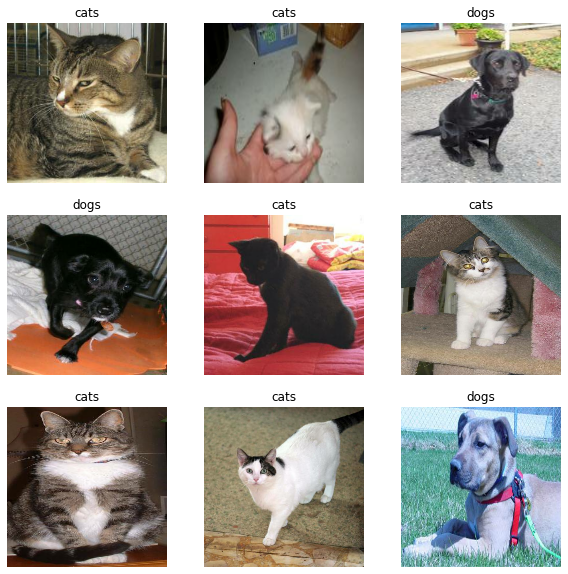

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

* 다운받은 데이터셋에 모델 평가를 위한 Test Data가 포함되어 있지 않으므로, 검증 데이터셋(Validation Dataset)의 일부를 나눠서 Test Dataset으로 만들어준다.

* Validation Dataset 에서 사용할 수 있는 데이터 배치 수 중 20%를 테스트 세트로 이동

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### 성능을 높이도록 데이터세트 구성하기

* prefetch 기법을 사용하여 Train/Validation Dataset에서 배치 데이터를 구성할 때 소비되는 시간을 좀 더 줄여주는 등 효율적인 데이터 로드가 가능

* 크게 중요하진 않음....

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강(Data Augmentation)

* Data Augmentation -> 데이터 증강

* 학습에 사용되는 데이터를 많이 확보하면 유리하지만, 데이터가 항상 부족한게 현실이다.

* 기존에 수집한 이미지 데이터를 축을 기준으로 회전하거나 수평으로 뒤집어주는 등 훈련 이미지에 무작위이지만 사실적인 변환을 적용하여 데이터셋의 다양성을 인위적으로 늘려주는 기법.
  
  -> 모델이 Train Dataset에만 매몰되어 학습하지 않은 데이터에 대한 성능이 낮아지는 것(과대적합)을 방지해주기 위한 대표적인 기법이라고 할 수 있음. 즉, 모델의 범용성/Capacity를 늘려주기 위한 방법이다.

  -> 이미지 Task 에서 성능향상을 위해 거의 100% 사용됨.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

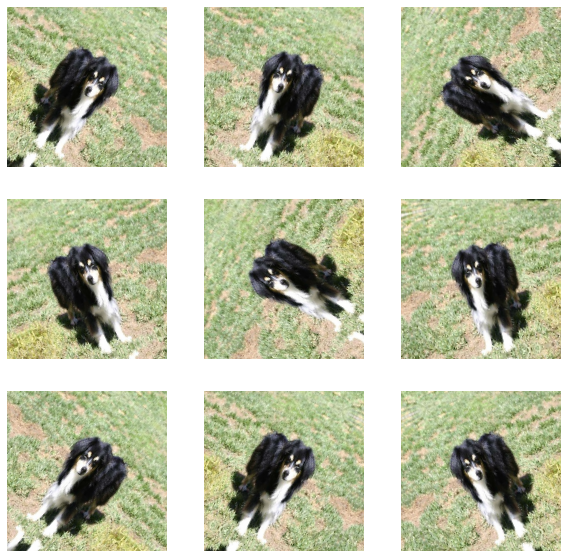

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 픽셀 값 재조정

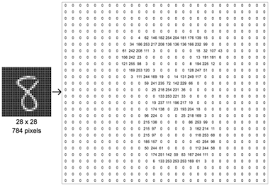

* Image Data의 일반적인 특성
  - 일반적인 이미지 데이터는 하나의 pixel당 0~255의 숫자값을 가짐
  - 픽셀값이 0에 가까울수록 어둡게 표현되고, 255에 가까울수록 밝게 표현됨.

* 학습에 사용할 MobileNet 모델은 이미지 데이터의 픽셀 값을 -1 ~ 1 사이의 값을 갖도록 전처리해서 Input 으로 넣어줘야함!
  - 모델마다 Input 데이터로 넣어줘야하는 조건들이 조금씩 다른 경우가 있으므로, 모델 사용 전 이에 대한 이해가 필요함
  - 사실 그냥 넣어도 Error 출력으로 이러한 조건들에 대해 알려주니깐, 모르면 일단 전처리 과정 없이 그냥 집어넣어 보면 된다.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## MobileNetv2 모델 가져오기

* MobileNetv2 모델
  - 논문 요약자료 참고 : https://greeksharifa.github.io/computer%20vision/2022/02/10/MobileNetV2/

* Tensorflow의 keras에서 MobileNetV2 모델과 ImageNet으로 학습한 결과인 Weight를  이미 제공하므로, 코드 한줄으로 MobileNetV2 모델 구조와 학습결과(weight)를 그대로 가지고 올 수 있음.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


* 각각의 160x160x3 구조의 이미지를 5x5x1280 개의 feature batch 변환

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### 베이스 모델 layer 가중치 고정

* 모델 훈련 전, 베이스 모델의 layer 가중치를 고정해주어야함!
* layer.trainable = False로 설정
* 이유는?
   - pre-train weight로 가져온 가중치들이 훈련 중에 임의로 업데이트되는 것을 방지함. layer 가중치를 고정해주지 않고 그냥 학습시킨다면, pre-trained weight를 가져온 의미가 없어짐.
   - 가져온 모델의 base layer의 가중치 값들은 모두 그대로 고정시켜 놓고, Custom Dataset으로 학습할 수 있도록 적합하게 새롭게 추가한 layer들의 가중치만 학습시켜 결과를 뽑아내는 것이 Transfer Learning의 핵심이다.

In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

### 수행하고자 하는 Task에 맞도록 이진분류 layer(Dense 층)를 맨 위에 추가

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


* 예제에서는 `tf.keras.layers.Dense` 레이어를 사용하여 특성을 이미지당 단일 예측으로 변환합니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측

* 최종적으로 Classification을 수행하기 위한 layer를 Dense(2)로 설정한 후, 활성화함수를 적용시켜 Classification을 수행할 수 도 있음!(이게 더 일반적인 방법인거 같은데...)

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 모델 컴파일

* 모델 학습 전 Compile 단계
  - 모델 학습시키기 위한 hyperparameter를 설정해줌
  - optimizer(최적화 기법), 학습률은 얼마로 할 것인지, loss function은 무엇을 사용할 것인지 등의 Hyperparameter를 코딩해주어야함.
  
* 분류하고자 하는 class가 개/고양이 2개의 Class 이므로 loss_function으로 이진분류에 적합한 BinaryCrossentropy 함수를 적용하였음.

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

* 아까 설정한 layer.trainable = False로 인해, MobileNet의 약 250만개의 가중치 중 220만개 고정, Dense 레이어에는 1200개의 훈련 가능한 가중치 존재

### 모델 훈련

* 최초 10 epoch만큼 반복 학습
* validation dataset을 통해 과대적합 여부를 체크해준다.

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 43ms/step - loss: 0.7687 - accuracy: 0.5408


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.77
initial accuracy: 0.54


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


63/63 [==============================] - 16s 160ms/step - loss: 0.7125 - accuracy: 0.5985 - val_loss: 0.5251 - val_accuracy: 0.6918
Epoch 2/10
63/63 [==============================] - 9s 133ms/step - loss: 0.5331 - accuracy: 0.6995 - val_loss: 0.3850 - val_accuracy: 0.7933
Epoch 3/10
63/63 [==============================] - 10s 163ms/step - loss: 0.4214 - accuracy: 0.7895 - val_loss: 0.3025 - val_accuracy: 0.8478
Epoch 4/10
63/63 [==============================] - 9s 147ms/step - loss: 0.3515 - accuracy: 0.8265 - val_loss: 0.2439 - val_accuracy: 0.9022
Epoch 5/10
63/63 [==============================] - 9s 146ms/step - loss: 0.3105 - accuracy: 0.8540 - val_loss: 0.2076 - val_accuracy: 0.9121
Epoch 6/10
63/63 [==============================] - 9s 132ms/step - loss: 0.2799 - accuracy: 0.8620 - val_loss: 0.1821 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 9s 134ms/step - loss: 0.2601 - accuracy: 0.8885 - val_loss: 0.1636 - val_accuracy: 0.9431
Epoch 8/10
63/6

### 학습결과 시각화

* Training Dataset의 정확도가 지속적으로 증가하고 loss가 감소함에 따라 Validation Dataset의 정확도 증가, loss 감소가 이루어지므로 과대적합 되지 않고 학습이 잘 되었다고 판단할 수 있음

* 과대적합(Overfitting) 이라고 판단하려면?
  - 과대적합이란 결국 모델이 훈련데이터만 학습하여, 훈련 데이터 외 학습하지 않은 일반적인 데이터에 대한 성능이 떨어지게 되는 현상을 말함. 인공지능의 목적은 훈련하지 않은 비슷한 데이터셋에도 일반적인 성능을 갖추게 하는것이 목적!
  - epoch가 반복되면서 모델이 학습하는 Training Dataset에 대한 Accuracy는 증가하고 loss가 계속 감소하는데, 모델이 학습하지 않는 Validation Dataset은 특정 시점부터 오히려 Accuracy가 감소하고 loss가 증가하는 시점이 생김.
  - 해당 시점부터 모델이 과대적합 되었다고 판단할 수 있음.
  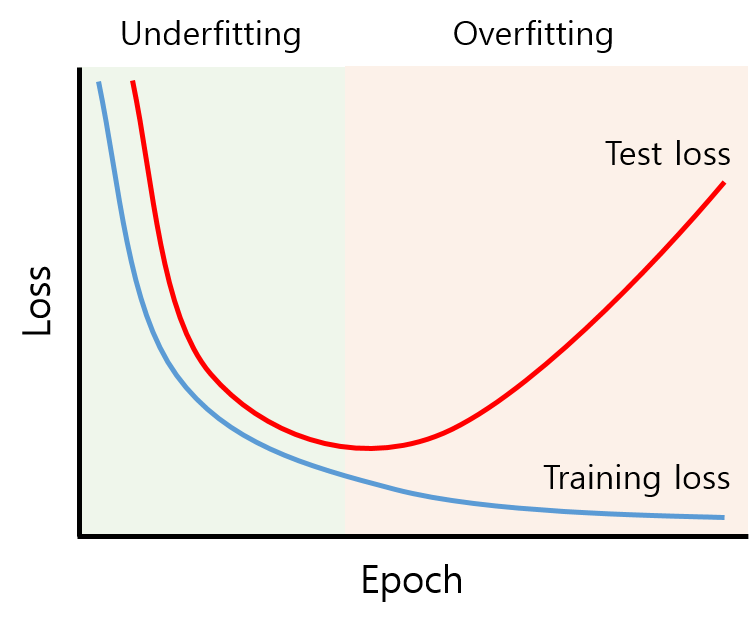

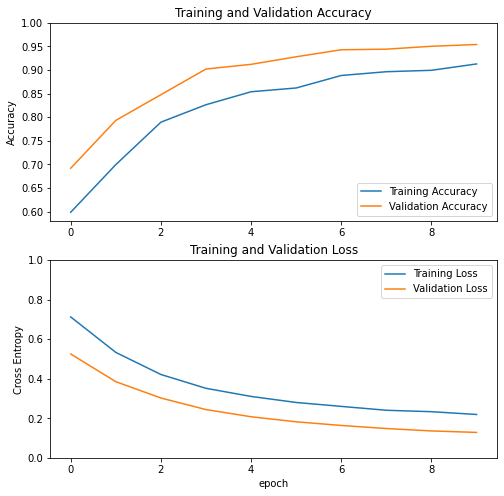

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

* 이 모델이 Overfitting 되지 않은 이유?(추정)
  - 최초 epoch가 10으로 매우 적었음
  - Base Model로 설정한 MobileNetv2 내에 dropout 층이 포함되어 있음.(Dense층 에서 임의의 노드를 dropout 시켜 과대적합 방지)

## 미세 조정(Fine Tuning)

* 학습이 잘 되었지만, 미세 조정(Fine Tuning)을 통해 성능을 조금 더 향상시킬 수 있음.

* Transfer Learning에서는 pre-train weight를 학습시킬 수 없도록 고정시킨 후, 추가한 모델의 최하위 layer의 Param만 학습시킴

* but, Fine Tuning에서는 학습데이터셋에 대한 일반적인 특성을 학습하는 모델의 최상위 layer만 미세조정으로 학습시키고, 이외의 층은 학습시킬 수 없도록 고정시켜준다.

* 일반적으로 훈련 데이터셋의 규모가 크고, pre-train 모델이 사용했던 원래 데이터셋과 Custom Dataset이 매우 유사한 경우에 권장됨.

### 최상위 층 고정 해제하기


* base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정
* 학습시킬 대상이 바뀌었으므로, 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련 시작

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### 모델 훈련 계속하기

* Custom Dataset에 맞게 정확도 추가 향상 가능

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


63/63 [==============================] - 23s 176ms/step - loss: 0.1539 - accuracy: 0.9345 - val_loss: 0.0564 - val_accuracy: 0.9839
Epoch 11/20
63/63 [==============================] - 10s 154ms/step - loss: 0.1341 - accuracy: 0.9455 - val_loss: 0.0521 - val_accuracy: 0.9790
Epoch 12/20
63/63 [==============================] - 10s 161ms/step - loss: 0.1150 - accuracy: 0.9490 - val_loss: 0.0592 - val_accuracy: 0.9728
Epoch 13/20
63/63 [==============================] - 10s 157ms/step - loss: 0.0931 - accuracy: 0.9585 - val_loss: 0.0464 - val_accuracy: 0.9876
Epoch 14/20
63/63 [==============================] - 10s 153ms/step - loss: 0.0937 - accuracy: 0.9570 - val_loss: 0.0382 - val_accuracy: 0.9839
Epoch 15/20
63/63 [==============================] - 10s 152ms/step - loss: 0.0686 - accuracy: 0.9720 - val_loss: 0.0388 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 12s 185ms/step - loss: 0.0688 - accuracy: 0.9730 - val_loss: 0.0386 - val_accuracy: 0.9864
Epoc

* 미세 조정 후 모델은 거의 98% 정확도에 도달

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

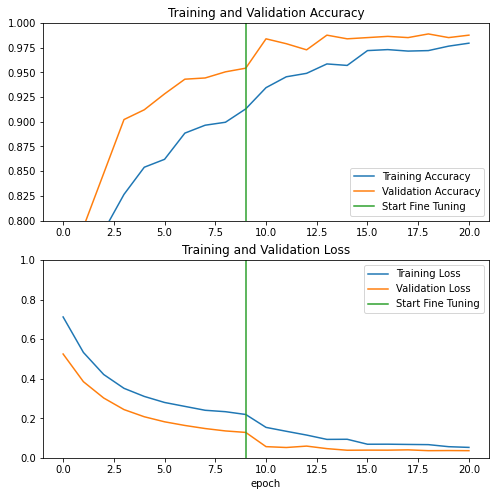

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 평가 및 예측

마지막으로 테스트 세트를 사용하여 새 데이터에 대한 모델의 성능을 확인할 수 있습니다.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 39ms/step - loss: 0.0585 - accuracy: 0.9740
Test accuracy : 0.9739583134651184


* 이제 이 모델을 사용하여 애완 동물이 고양이인지 개인지 예측가능함
* 모델 출력 값이 0이면 Cat, 1이면 Dog

Predictions:
 [0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0]
Labels:
 [0 1 1 1 0 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 0]


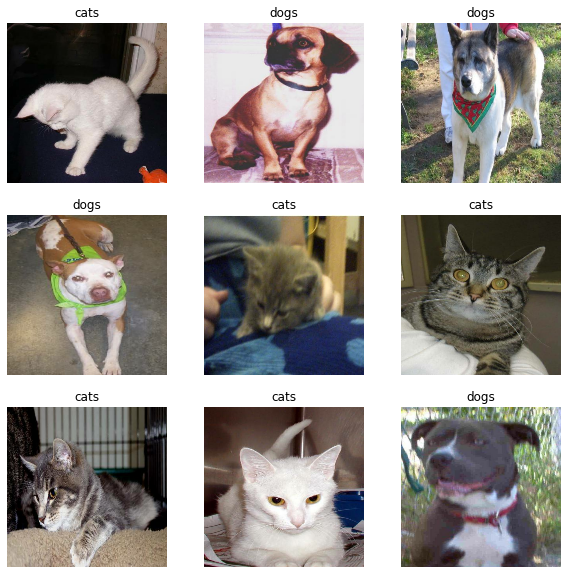

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")